# Fetch Some Audio

First, we'll fetch some audio from the internet, grab the first five seconds, and convert it to mono

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import zounds
import requests
from io import BytesIO

# fetch some audio of a Bach piece from Internet Archive
url = 'https://ia802606.us.archive.org/9/items/AOC11B/onclassical_luisi_bach_partita_B-flat-major_bwv-825_1.ogg'
resp = requests.get(url, stream=True)
bio = BytesIO(resp.content)


# load and decode the audio samples
samples = zounds.AudioSamples.from_file(bio)
# take a slice of the first five seconds
samples = samples[:zounds.Seconds(5)]
# convert to mono
samples = samples.mono

/home/user/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Listen (and look) at the Audio Samples

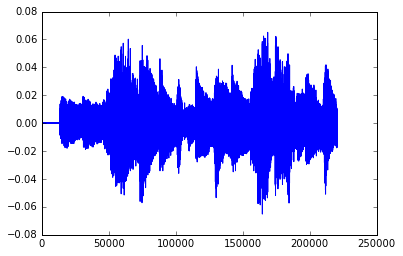

In [2]:
plt.plot(samples)
import IPython.display as ipd
ipd.Audio(samples, rate=int(samples.samplerate))

# A Time-Frequency Representation

Let's compute a time-frequency representation of the signal using the [short-time fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform), which computes the fourier transform of short (~40ms), overlapping windows of audio.  This is a long enough window to give us fairly good frequency resolution, and the short, overlapping windows allow us to localize the frequencies well in time.

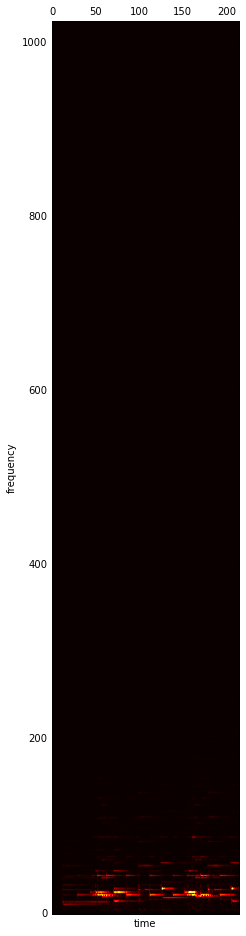

In [17]:
import numpy as np
time_frequency = zounds.spectral.stft(samples)

# take the absolute value of the magnitudes, and
# discard phase information
time_frequency = np.abs(time_frequency)

plt.matshow(time_frequency.T, cmap='hot', origin='lower')
plt.xlabel('time')
plt.ylabel('frequency')

# Log-Spaced Frequencies

There are a couple problems with the representation above.  The first is that we tend to [perceive frequency on a roughly logarithmic scale](https://en.wikipedia.org/wiki/Mel_scale), but the FFT frequencies lie along a linear scale.  Put another way, we can notice very small frequency variations in lower frequencies, but require much larger changes in higher frequencies in order for them to be perceptible.

Here we'll create a basis to map the linear FFT frequencies onto a logarithmic scale.

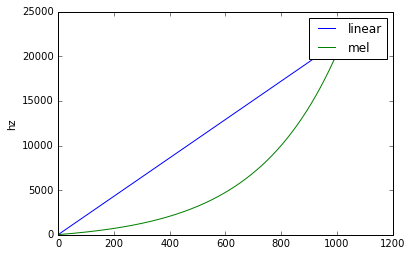

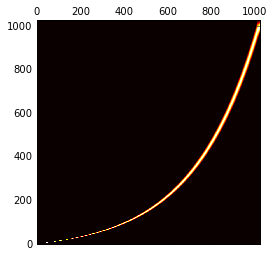

In [14]:
# plot the linear frequencies 
linear_scale = time_frequency.dimensions[-1].scale
plt.plot([band.center_frequency for band in linear_scale], label='linear')

# instantiate a Mel scale, and plot its frequencies
band = zounds.FrequencyBand(20, samples.samplerate.nyquist)
n_filters = 1024
scale = zounds.MelScale(band, n_filters)
plt.plot([band.center_frequency for band in scale], label='mel')

plt.ylabel('hz')
plt.legend()

# plot a basis we can use to map linear FFT frequencies onto the 
# logaritmic mel scale
mel_scale_basis = scale._basis(linear_scale, zounds.HanningWindowingFunc())
plt.matshow(mel_scale_basis.T, origin='lower', cmap='hot')

# Map onto the Mel Scale

If we take the dot product of our mel basis above and each FFT frame, we get a new time-frequency representation with the linear FFT frequencies mapped onto a Mel scale.

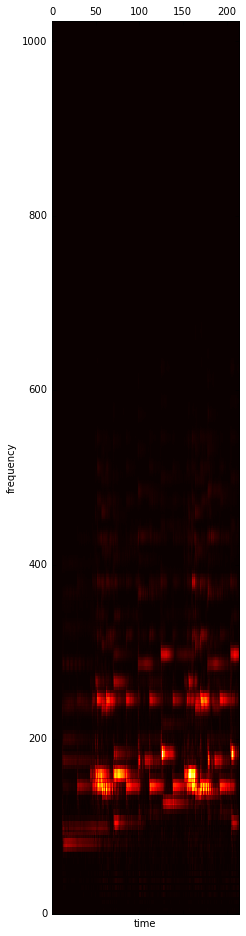

In [16]:
mel_spectrogram = scale.apply(time_frequency, zounds.HanningWindowingFunc())
plt.matshow(mel_spectrogram.T, cmap='hot', origin='lower')
plt.xlabel('time')
plt.ylabel('frequency')

# Log Amplitude

The other problem with the short-time fourier transform is that we also tend to [perceive loudness on a logarithmic scale](https://en.wikipedia.org/wiki/Decibel#Acoustics).  Here, we'll use a commonly-used approximation for computing decibels from the raw magnitudes.  This will have the effect of "compressing" the magnitudes: making loud events a little quieter, and quiet events a little louder.

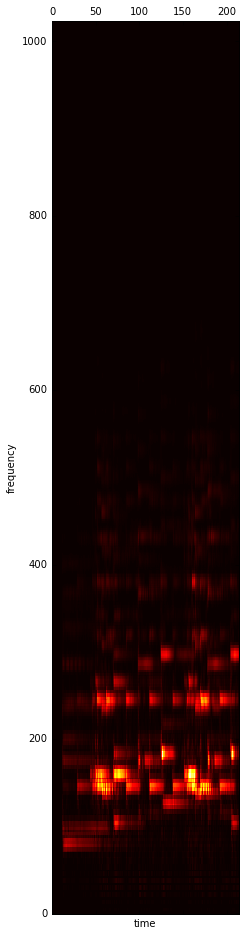

In [18]:
log_amplitude = 20 * np.log10(1 + mel_spectrogram)
plt.matshow(log_amplitude.T, cmap='hot', origin='lower')
plt.xlabel('time')
plt.ylabel('frequency')

# Another Interpretation

You can think of the weights of a convolutional neural network as a bank of finite impulse response filters.  First, let's build a bank of filters with frequencies centered on bands of the logarithmic mel scale from above and visualize some of the filters.

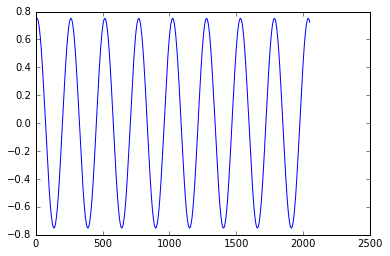

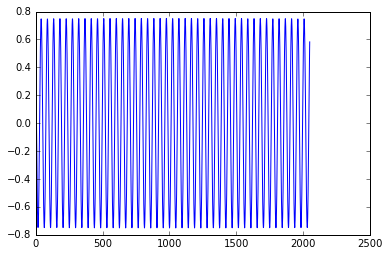

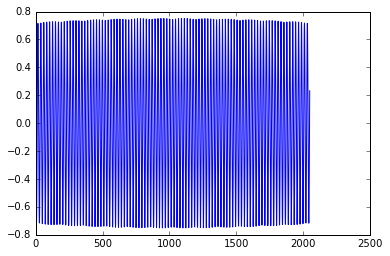

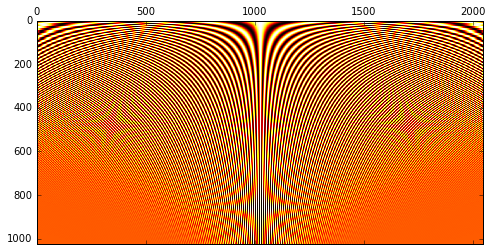

In [7]:
from scipy.signal import morlet

def make_filter_bank(samplerate, basis_size, kernel_size, scale):
    """
    Create a bank of finite impulse response filters, with 
    frequencies centered on the sub-bands of scale
    """
    basis = np.zeros((basis_size, kernel_size), dtype=np.complex128)
    
    # cycles determines the tradeoff between time and frequency 
    # resolution.  We'd like good frequency resolution for lower
    # frequencies, and good time resolution for higher ones
    cycles = np.geomspace(2048, 128, basis_size)
    
    for i, band in enumerate(scale):
        basis[i] = morlet(
            kernel_size, # wavelet size
            cycles[i], # time-frequency resolution tradeoff 
            (band.center_frequency / samplerate.nyquist)) # frequency
    return basis.real

kernel_size = 2048
filter_bank = make_filter_bank(
    samplerate=samples.samplerate, 
    basis_size=n_filters, 
    kernel_size=kernel_size, 
    scale=scale)

plt.plot(filter_bank[10, :])
plt.show()
plt.plot(filter_bank[100, :])
plt.show()
plt.plot(filter_bank[256, :])
plt.show()

plt.matshow(filter_bank, cmap='hot')

# Computing a Time-Frequency Representation with Convolution

Finally, we can compute a similar representation to the one above by convolving our filter bank with the raw samples to obtain a mel scale log-amplitude spectrogram.

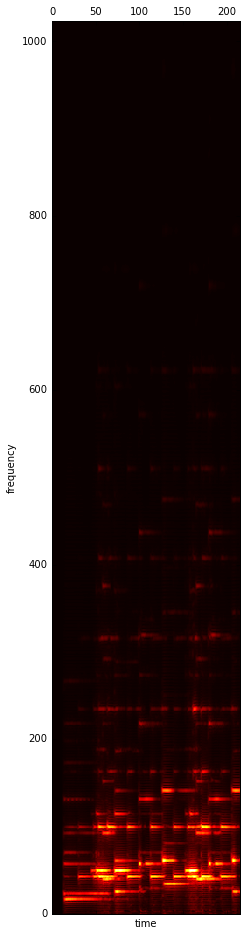

In [19]:
import torch
from torch.nn import functional as F

# convert our filter bank to a PyTorch tensor
weights = torch.from_numpy(filter_bank)\
    .view(len(scale), 1, kernel_size)\
    .float()

# convert the raw audio samples to a PyTorch tensor
tensor_samples = torch\
    .from_numpy(samples)\
    .view(1, 1, -1)\
    .float()

# convolve the filter bank with the samples
spectral = F.conv1d(tensor_samples, weights, padding=weights.shape[-1] // 2)

# compute log-scale magnitudes
spectral = F.relu(spectral)
spectral = 20 * torch.log10(spectral + 1)

# pool over short, overlapping windows, discarding phase
# information
spectral = F.avg_pool1d(
    spectral, 
    kernel_size=2048, 
    stride=1024, 
    padding=1024)


spectral = spectral.data.cpu().numpy().squeeze()
plt.matshow(spectral, cmap='hot', origin='lower')
plt.xlabel('time')
plt.ylabel('frequency')